simple_XRD.jl
by Hezy Amiel
January 2023
Julia 1.8.5

In [262]:
using Plots, SpecialFunctions, Random, Distributions

In [266]:
Random.seed!(347) # Setting the seed

TaskLocalRNG()

#Function

In [38]:
function Gaussian(x, fwhm)
    σ = fwhm/(2√(2log(2)))
    return @. 1/√(2π)/σ * exp(-x^2/2σ^2)
end

Gaussian (generic function with 1 method)

In [39]:
function Lorentzian(x, fwhm)
    γ = fwhm / 2
    return @. (γ/pi) / (x^2 + γ^2)
end

Lorentzian (generic function with 1 method)

In [40]:
function Pseudo_Voigt(x, fwhm, n)
	return n * Lorentzian(x, fwhm) + (1 - n) * Gaussian(x, fwhm)
end

Pseudo_Voigt (generic function with 1 method)

In [41]:
function Voigt(x, fwhm_L, fwhm_G)
    γ = fwhm_L/2
    σ = fwhm_G/(2√(2log(2)))
    z = @. -im * (x + im * γ) / (√2 * σ)
    return @. real(erfcx(z)) / (√(2pi) * σ)
end

Voigt (generic function with 1 method)

In [42]:
function peak(θ, θ₀, A, w, n)
    return @. A * Pseudo_Voigt(θ-θ₀, w, n)
end

peak (generic function with 1 method)

In [43]:
function peaks_width(two_θ_deg, U, V, W)
    two_θ_rad = two_θ_deg * π/180
    return @. √(U * tan(two_θ_rad/2)^2 + V * tan(two_θ_rad/2) + W)
end

peaks_width (generic function with 1 method)

In [44]:
function bragg_angels(wavelength, d_spacings)
    sinθ = wavelength ./ (2*d_spacings)
    sinθ_cleaned = [item for item in sinθ if abs(item)<=1]  # removing values outside (-1,1)
    return 2 * (180/π) * asin.(sinθ_cleaned)  # *2 for 2θ  
end

bragg_angels (generic function with 1 method)

In [45]:
function d_list(indices, a)
    return a ./ .√(sum(indices.^2, dims=2))
end

d_list (generic function with 1 method)

In [46]:
function sum_peaks(θ, two_θ_list, U, V, W)
    y = zeros(size(θ))
    for item in two_θ_list
        y = y + peak(θ, item, 1, peaks_width(θ, U, V, W), 0.5)
    end
    return y
end


sum_peaks (generic function with 1 method)

In [47]:
function intensity_vs_angle(θ, indices, λ, a, U, V, W)
    indices = (reduce(hcat, indices))'
    two_θ_list = bragg_angels(λ, d_list(indices, a));
    y = sum_peaks(θ, two_θ_list, U, V, W)
    return y
end

intensity_vs_angle (generic function with 1 method)

In [48]:
function plot_it(θ, y, Title)
    p = plot(θ, y)
    title!(Title)
    xlabel!(raw"2θ (deg)")
    ylabel!(raw"Intensity (arb.)")
    return p
end

plot_it (generic function with 1 method)

In [49]:
function Miller_indices(cell_type, min, max)
    if cell_type == "SC"
        # In simple cubic lattince, all Miller indices are allowed
        return [[h,k,l] for h=min:max for k=min:max for l=min:max if [h,k,l]!=[0,0,0]]
    elseif cell_type == "BCC"
        # In body centerd cubic lattice, only indices with h+k+l=even are allowed
        return [[h,k,l] for h=min:max for k=min:max for l=min:max if iseven(h+k+l) && [h,k,l]!=[0,0,0]]
    elseif cell_type == "FCC"
        # In face centered cubic lattice, h,k,l must all be either odd or even
        return [[h,k,l] for h=-5:5 for k=-5:5 for l=-5:5 if 
                ((iseven(h) && iseven(k) && iseven(l))||
                (isodd(h) && isodd(k) && isodd(l))) 
                && [h,k,l]!=[0,0,0]]
    else return [0,0,0]
    end
end

Miller_indices (generic function with 1 method)

In [279]:
function background(θ, a0, a1, a2, a3, a4, a5)
    return @. a0 + a1*θ + a2*θ^2 + a3*θ^3 + a4*θ^4 + a5*θ^5
end

background (generic function with 1 method)

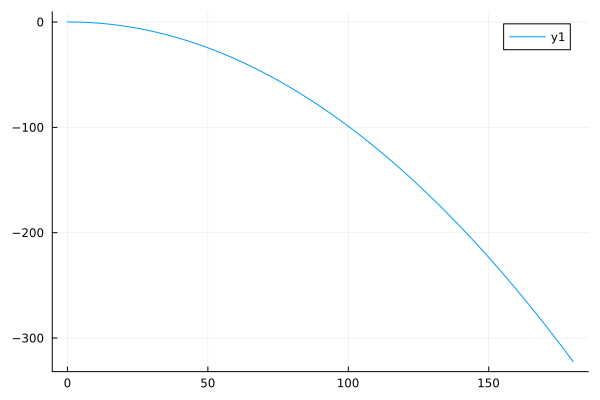

In [285]:
y = background(θ, 0.01, 0.01, -0.01, 0, -0, 0)
plot(θ,y)

#General Settings

In [50]:
N = 1000   
θ = collect(LinRange(0, 180, N))
y = zeros(N)
λ = 0.15418  # CuKα radiation in nm
U, V, W = 0.2, 0.2, 0.2

(0.2, 0.2, 0.2)

#Simple Cubic

In [277]:
"""
Lattice parameter for SC Polonium (α-Po)
from https://en.wikipedia.org/wiki/Polonium 
"""
a_SC = 0.3352

indices_SC = Miller_indices("SC", -5, 5)

y_SC_background = background(θ, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01)

y_SC = @. (y_SC_background + intensity_vs_angle(θ, indices_SC, λ, a_SC, U, V, W)) * rand(Normal(1, 0.3), N)

plot_it(θ, y_SC, "XRD - SC")

MethodError: MethodError: no method matching ^(::Vector{Float64}, ::Int64)
Closest candidates are:
  ^(!Matched::Union{AbstractChar, AbstractString}, ::Integer) at strings/basic.jl:730
  ^(!Matched::Rational, ::Integer) at rational.jl:477
  ^(!Matched::LinearAlgebra.Symmetric{var"#s886", S} where {var"#s886"<:Real, S<:(AbstractMatrix{<:var"#s886"})}, ::Integer) at ~/.julia/juliaup/julia-1.8.5+0.x64.linux.gnu/share/julia/stdlib/v1.8/LinearAlgebra/src/symmetric.jl:674
  ...

#Body Centered Cubic

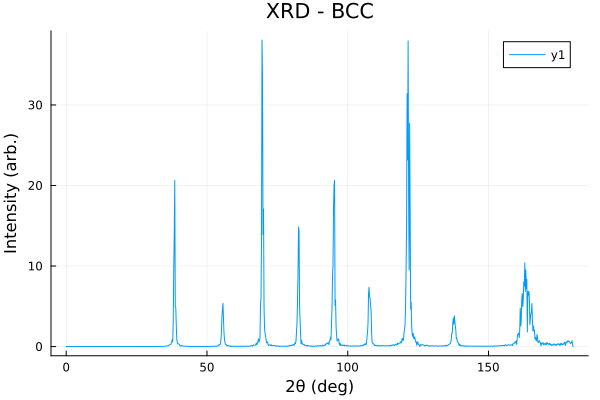

In [270]:
"""
Lattice parameter for BCC Tantalum (α-Ta)
from https://en.wikipedia.org/wiki/Tantalum
"""
a_BCC = 0.33058

#"""
#Lattice parameter for BCC Tungsten (W)
#from https://en.wikipedia.org/wiki/Lattice_constant
#"""
#a_BCC = 0.3155

indices_BCC = Miller_indices("BCC", -5, 5)

y_BCC = intensity_vs_angle(θ, indices_BCC, λ, a_BCC, U, V, W) .* rand(Normal(1, 0.3), N)

plot_it(θ, y_BCC, "XRD - BCC")

#Face Centered Cubic

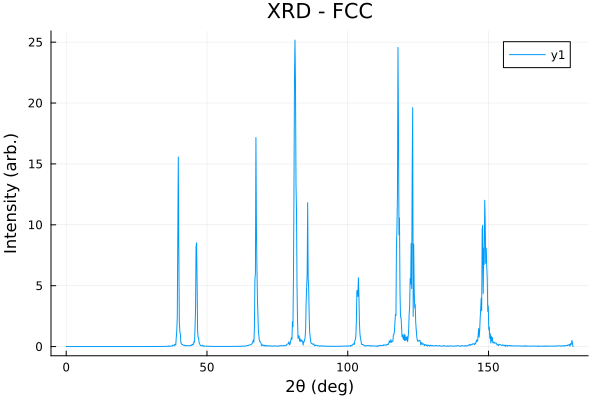

In [271]:
"""
Lattice parameter for FCC Platinum
from https://periodictable.com/Elements/078/data.html
"""
a_FCC = 0.39242 

#"""
#Lattice parameter a for FCC Pb
#from https://en.wikipedia.org/wiki/Lattice_constant
#"""
#a_FCC = 0.4920 

indices_FCC = Miller_indices("FCC", -5, 5)
                
y_FCC = intensity_vs_angle(θ, indices_FCC, λ, a_FCC, U, V, W) .* rand(Normal(1, 0.3), N)

plot_it(θ, y_FCC, "XRD - FCC")                   